In [1]:
from Dataset_Loader import load_leafs_dataset
from Training import train_cnn
from Model_Evaluation import evaluate_model_with_outputs
import matplotlib.pyplot as plt
import cv2
from torch import nn, optim, flatten, manual_seed
from Util import apply_conv, apply_pool

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        width = 1633
        height = 1089
        self.pool1, width, height = apply_pool(width, height, kernel_size=2, stride=2)
        self.pool2, width, height = apply_pool(width, height, kernel_size=2, stride=2)
        self.pool3, width, height = apply_pool(width, height, kernel_size=2, stride=2)
    
        self.conv1, width, height = apply_conv(width, height, 1, 6, kernel_size=3, stride=1, padding=0)
        self.pool4, width, height = apply_pool(width, height, kernel_size=2, stride=2)

        self.conv2, width, height = apply_conv(width, height, 6, 16, kernel_size=3, stride=1, padding=0)
        self.pool5, width, height = apply_pool(width, height, kernel_size=2, stride=2)

        self.fc1 = nn.Linear(16*width*height, 1000)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1000, 99)
        self.dropout2 = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool1(x)
        x = self.pool2(x)
        x = self.pool3(x)

        x = nn.functional.relu(self.conv1(x))
        x = self.pool4(x)

        x = nn.functional.relu(self.conv2(x))
        x = self.pool5(x)

        x = flatten(x, 1)
        x = self.dropout1(nn.functional.relu(self.fc1(x)))
        x = nn.functional.log_softmax(self.dropout2(self.fc2(x)), dim=1)
        return x

In [3]:
images_train, images_test, labels_train, labels_test = load_leafs_dataset(
    0.2,
    32)

Reading CSV: 0.03 seconds
Encoding Labels: 0.0 seconds
Resizing Images: 2.451 seconds
Splitting Data: 0.301 seconds
Converting To Tensor: 0.966 seconds
Dividing To Batches: 0.0 seconds


In [4]:
manual_seed(1)
model = CNN()
optimizer = optim.Adam(model.parameters(), 0.001)
epochs = 10
trained_model, train_losses = train_cnn(
    model=model,
    input_tensor=images_train,
    output_tensor=labels_train,
    epochs=epochs,
    batch_size=8,
    lossFunction=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    print_loss=True
    )

Epoch: 0 / loss: 165.222900390625
Epoch: 1 / loss: 16.595352172851562
Epoch: 2 / loss: 6.448267459869385
Epoch: 3 / loss: 2.8131775856018066
Epoch: 4 / loss: 2.2201662063598633
Epoch: 5 / loss: 0.8288147449493408
Epoch: 6 / loss: 1.6608128547668457
Epoch: 7 / loss: 1.689224123954773
Epoch: 8 / loss: 1.6986103057861328
Epoch: 9 / loss: 1.3527268171310425


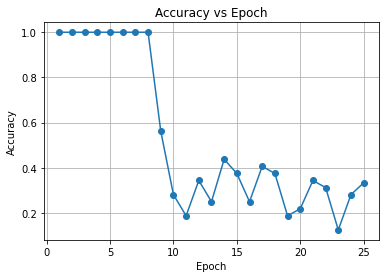

0 Model Accuracy: 195.37%


TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [5]:
train_accuracy = evaluate_model_with_outputs(model, images_train, labels_train, 8, 0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
test_accuracy = evaluate_model_with_outputs(model, images_test, labels_test, 8, 1)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")